# (03) Fisher: Lin

**Motivation**: Fisher metric for linear models (OLS).

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Load

In [3]:
# skip + x
# model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
# fit_name = 'ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_24,18:00)'

# skip + 0.1 * x
model_name = 'fixate1_k-32_z-14x[5,10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'skip+0.1x_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_30,09:01)'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    verbose=True,
    device='cuda',
    shuffle=False,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  39.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  22.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  3.0 Mil   |
| dec_sampler  |  3.0 Mil   |
|    expand    |  287.1 K   |
|  dec_tower   |  10.3 Mil  |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 39.3 M

## Linear models

### LR

In [4]:
g, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + [
        'slf_v_norm',
        'slf_v_theta',
        'slf_v_phi']
)
print({k: v.shape for k, v in g.items()})

{'trn': (600000, 14), 'vld': (75000, 14), 'tst': (75000, 14)}

In [5]:
%%time

z = {
    k: tr.forward(k, True)[0]['z']
    for k in g
}
print({k: v.shape for k, v in z.items()})

{'trn': (600000, 490), 'vld': (75000, 490), 'tst': (75000, 490)}

CPU times: user 3min 53s, sys: 39 s, total: 4min 32s
Wall time: 4min 32s


In [6]:
idx = 5
idx, select_lbl[idx]

(5, 'obj0_alpha_x')

In [7]:
lr = sk_linear.LinearRegression().fit(z['trn'], g['trn'][:, idx])
pred = lr.predict(np.concatenate([z['vld'], z['tst']]))
true = np.concatenate([g['vld'], g['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.928416167761235

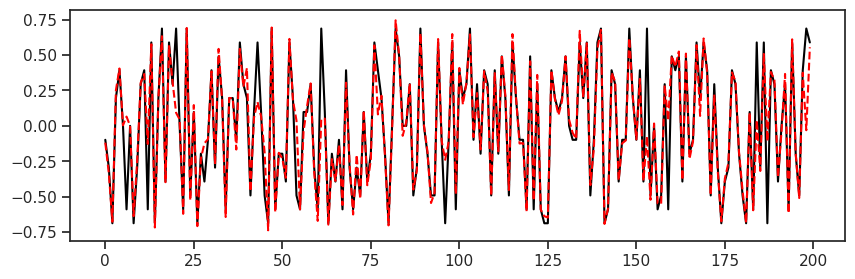

In [9]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(true[:200], 'k')
ax.plot(pred[:200], 'r--')
plt.show()

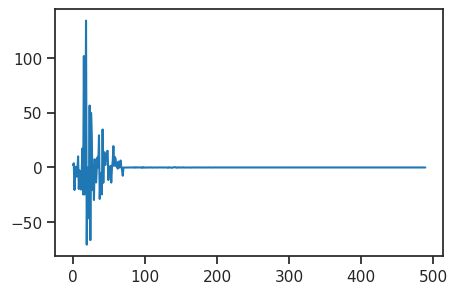

In [10]:
plt.plot(lr.coef_)

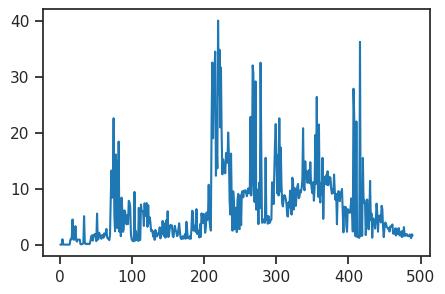

In [11]:
plt.plot(z['trn'].std(0))

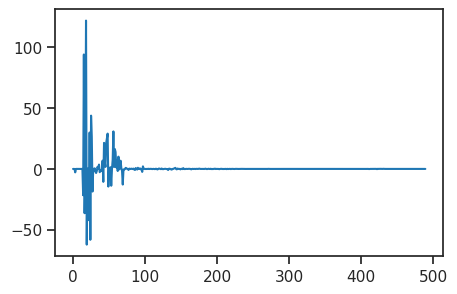

In [12]:
plt.plot(lr.coef_ * z['trn'].std(0))

In [13]:
w = lr.coef_.reshape(1, -1)
w = w.T @ w
w.shape

(490, 490)

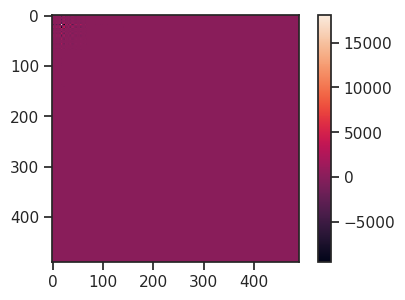

In [14]:
plt.imshow(w)
plt.colorbar()

In [15]:
u, s, v = sp_lin.svd(w, full_matrices=False)
s[0], s[1], s[2]

(57018.496, 0.015925767, 0.015805637)

In [16]:
sp_stats.pearsonr(v[0], lr.coef_)

(-0.9999999999999982, 0.0)

### Lasso

In [27]:
lasso = sk_linear.Lasso(
    alpha=0.01,
    random_state=0,
).fit(z['trn'], g['trn'][:, idx])
pred = lasso.predict(np.concatenate([z['vld'], z['tst']]))
true = np.concatenate([g['vld'], g['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.9065606320448468

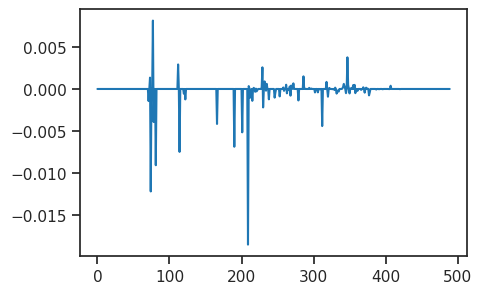

In [28]:
plt.plot(lasso.coef_);

In [38]:
ftr_ids = np.where(np.abs(lasso.coef_) > 1e-3)[0]
len(ftr_ids)

23

In [39]:
lr2 = sk_linear.LinearRegression().fit(z['trn'][:, ftr_ids], g['trn'][:, idx])
pred = lr2.predict(np.concatenate([z['vld'], z['tst']])[:, ftr_ids])
true = np.concatenate([g['vld'], g['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.9006795696834452

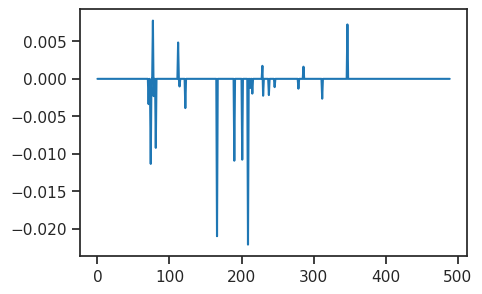

In [40]:
w = np.zeros(len(lr.coef_))
w[ftr_ids] = lr2.coef_

plt.plot(w);

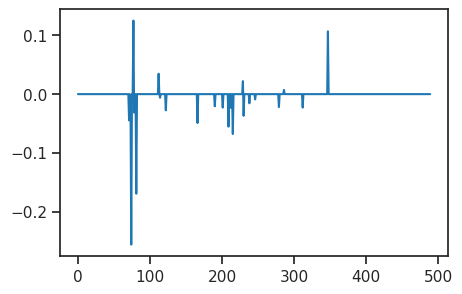

In [41]:
w = np.zeros(len(lr.coef_))
w[ftr_ids] = lr2.coef_
w *= z['trn'].std(0)

plt.plot(w);

## Z-score

In [110]:
g_zscored = np.concatenate([v for v in g.values()])
mu = g_zscored.mean(0, keepdims=True)
sd = g_zscored.std(0, keepdims=True)

g_zscored = {
    k: (v - mu) / sd
    for k, v in g.items()
}
print({
    k: (v.mean(0).mean(), v.std(0).mean())
    for k, v in g_zscored.items()
})

{
    'trn': (-0.0001552203239358355, 0.9999721681464211),
    'vld': (0.0001768798982501835, 0.9998670914435488),
    'tst': (0.0010648826932356669, 1.0003359469796766)
}

In [111]:
z_zscored = np.concatenate([v for v in z.values()])
mu = z_zscored.mean(0, keepdims=True)
sd = z_zscored.std(0, keepdims=True)

z_zscored = {
    k: (v - mu) / sd
    for k, v in z.items()
}
print({
    k: (v.mean(0).mean(), v.std(0).mean())
    for k, v in z_zscored.items()
})

{
    'trn': (-7.9850076e-07, 0.9999362),
    'vld': (0.00011585294, 1.0006844),
    'tst': (7.2752982e-06, 1.000606)
}

In [96]:
idx = 5
idx, select_lbl[idx]

(5, 'obj0_alpha_x')

In [113]:
lr = sk_linear.LinearRegression().fit(z_zscored['trn'], g_zscored['trn'][:, idx])
pred = lr.predict(np.concatenate([z_zscored['vld'], z_zscored['tst']]))
true = np.concatenate([g_zscored['vld'], g_zscored['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.9289348114303185

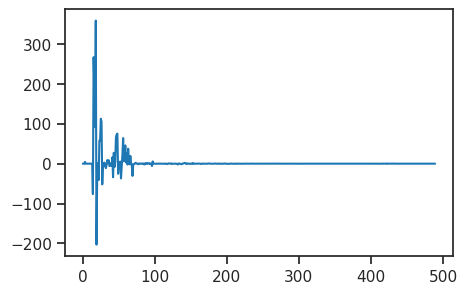

In [125]:
plt.plot(lr.coef_);

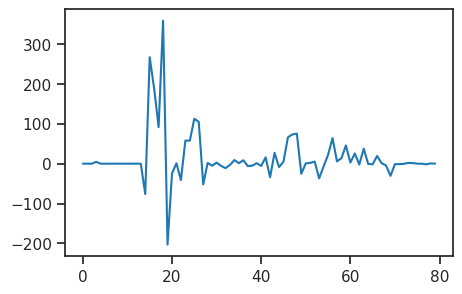

In [127]:
plt.plot(lr.coef_[:80])

### Lasso

In [119]:
lasso = sk_linear.Lasso(
    alpha=0.01,
    random_state=0,
).fit(z_zscored['trn'], g_zscored['trn'][:, idx])
pred = lasso.predict(np.concatenate([z_zscored['vld'], z_zscored['tst']]))
true = np.concatenate([g_zscored['vld'], g_zscored['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.9018339661862539

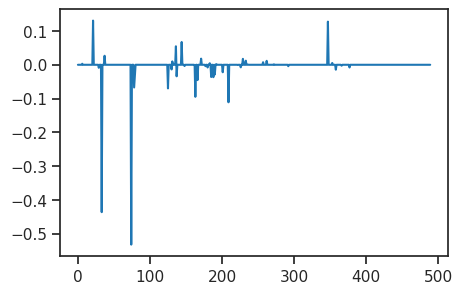

In [120]:
plt.plot(lasso.coef_);

In [136]:
ftr_ids = np.where(np.abs(lasso.coef_) > 1e-2)[0]
len(ftr_ids)

24

In [137]:
lr2 = sk_linear.LinearRegression().fit(z_zscored['trn'][:, ftr_ids], g_zscored['trn'][:, idx])
pred = lr2.predict(np.concatenate([z_zscored['vld'], z_zscored['tst']])[:, ftr_ids])
true = np.concatenate([g_zscored['vld'], g_zscored['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.9047753282275824

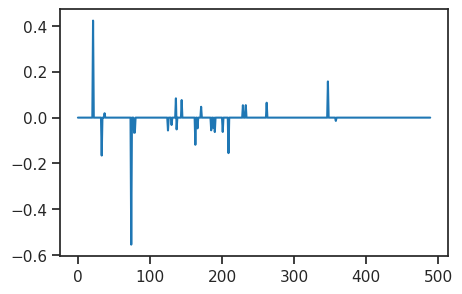

In [138]:
w = np.zeros(len(lr.coef_))
w[ftr_ids] = lr2.coef_

plt.plot(w);

---
---
---

## New test

### Get samples

In [4]:
x, _ = next(iter(tr.dl_trn))
z_list, _, x_hat, q, p = tr.model.xtract_ftr(x)
x_hat = to_np(x_hat)
x = to_np(x)

In [6]:
g, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + [
        'slf_v_norm',
        'slf_v_theta',
        'slf_v_phi']
)
z = {
    k: tr.forward(k, True)[0]['z']
    for k in g
}

In [7]:
idx = 5
idx, select_lbl[idx]

(5, 'obj0_alpha_x')

In [8]:
g['trn'][sample_i, idx]

-0.5890486225480862

### LR

In [10]:
lr = sk_linear.LinearRegression().fit(z['trn'], g['trn'][:, idx])
pred = lr.predict(np.concatenate([z['vld'], z['tst']]))
true = np.concatenate([g['vld'], g['tst']])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.928416167761235

### Traverse along $\hat{u}$

In [28]:
sp_lin.norm(lr.coef_)

238.7854766845703

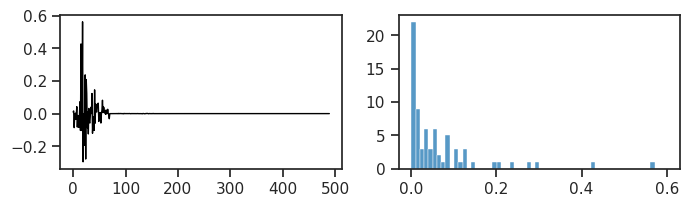

In [29]:
u_hat = lr.coef_ / sp_lin.norm(lr.coef_)

fig, axes = create_figure(1, 2, (8, 2))
axes[0].plot(u_hat, lw=1, color='k')
sns.histplot(np.abs(u_hat), bins=np.linspace(0.001, 0.6 + 0.001, 61), ax=axes[1])
axes[1].set_ylabel('')
plt.show()

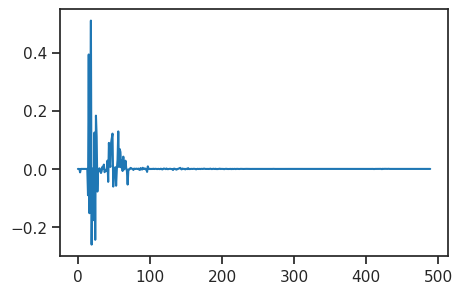

In [30]:
plt.plot(u_hat * z['trn'].std(0))

In [31]:
nz = tr.model.cfg.n_latent_per_group
n_groups = sum(tr.model.cfg.groups)
nz, n_groups

(14, 35)

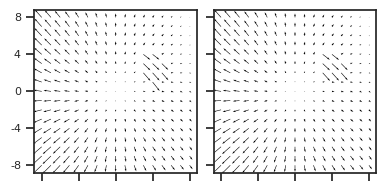

In [55]:
sample_i = 456
show_opticflow(np.stack([
    x[sample_i], x_hat[sample_i],
]));

In [56]:
n = 16
delta = 3000.0
z_trav = []
for i in range(n_groups):
    u = u_hat[range(i * nz, (i + 1) * nz)]
    u = tr.to(u).unsqueeze(-1).unsqueeze(-1)
    u.mul_(delta)
    z_trav.append(tr.to(interp(
        xi=z_list[i][sample_i] - u,
        xf=z_list[i][sample_i] + u,
        n=n,
    )))

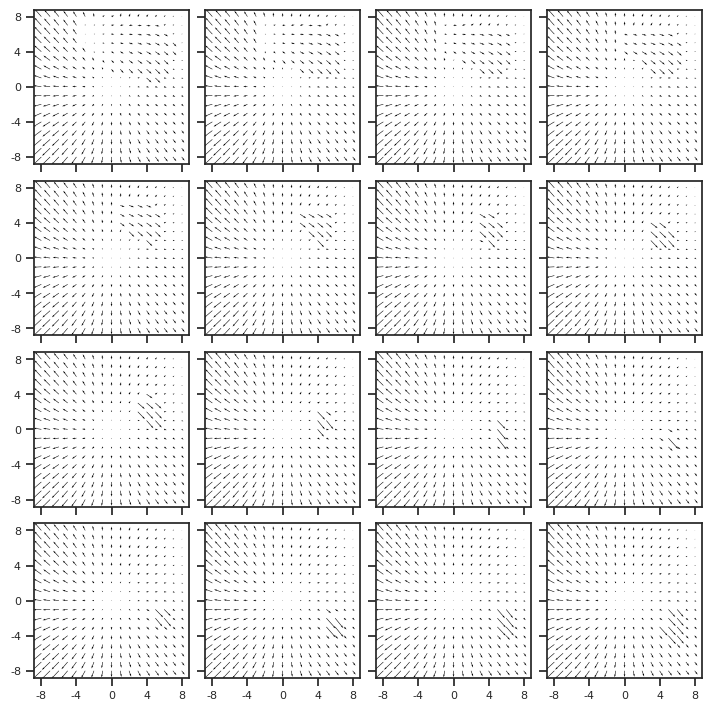

In [57]:
x_trav = tr.model.generate(z_trav)
fig, _ = show_opticflow(x_trav)

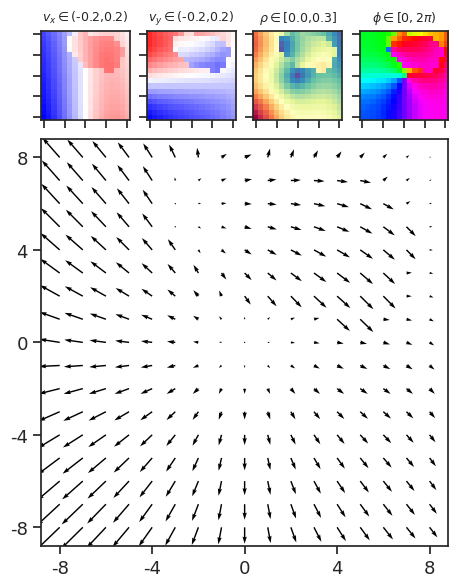

In [58]:
show_opticflow_full(x_trav[0]);

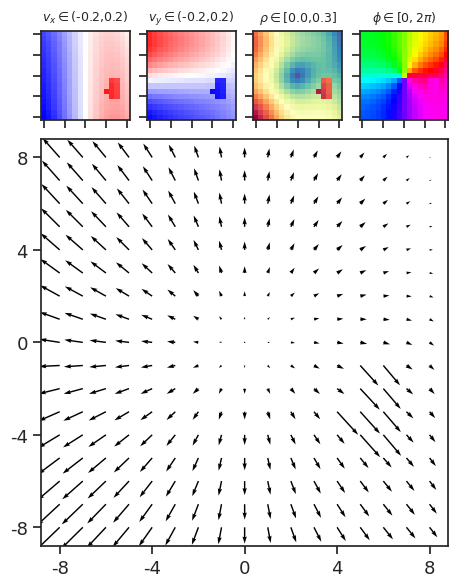

In [59]:
show_opticflow_full(x_trav[-1]);

In [97]:
u_all, r2_all = {}, {}
for idx, lbl in tqdm(enumerate(select_lbl), total=len(select_lbl)):
    # fit + get coeff
    lr = sk_linear.LinearRegression().fit(z['trn'], g['trn'][:, idx])
    u_all[lbl] = lr.coef_ / sp_lin.norm(lr.coef_)
    # r2
    pred = lr.predict(np.concatenate([z['vld'], z['tst']]))
    true = np.concatenate([g['vld'], g['tst']])[:, idx]
    r2 = sk_metric.r2_score(true, pred)
    r2_all[lbl] = r2
np.mean(list(r2_all.values()))

100%|███████████████████████████████████████████| 14/14 [01:18<00:00,  5.61s/it]


0.8964224416082128

In [98]:
r2_all

{'fix_x': 0.9866207584318322,
 'fix_y': 0.9850905207783375,
 'slf_v_x': 0.9883014030425469,
 'slf_v_y': 0.9809570770305774,
 'slf_v_z': 0.9894181208492068,
 'obj0_alpha_x': 0.928416167761235,
 'obj0_alpha_y': 0.9112833807895413,
 'obj0_size': 0.9812670013152259,
 'obj0_v_x': 0.7940990728562863,
 'obj0_v_y': 0.8344286774806572,
 'obj0_v_z': 0.7436672092773237,
 'slf_v_norm': 0.9929478778145777,
 'slf_v_theta': 0.8159824910320724,
 'slf_v_phi': 0.6174344240555623}

In [99]:
pred = lr.predict(z['trn'])
true = g['trn'][:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.6212431508594928

In [100]:
u = np.stack(list(u_all.values()))
u.shape

(14, 490)

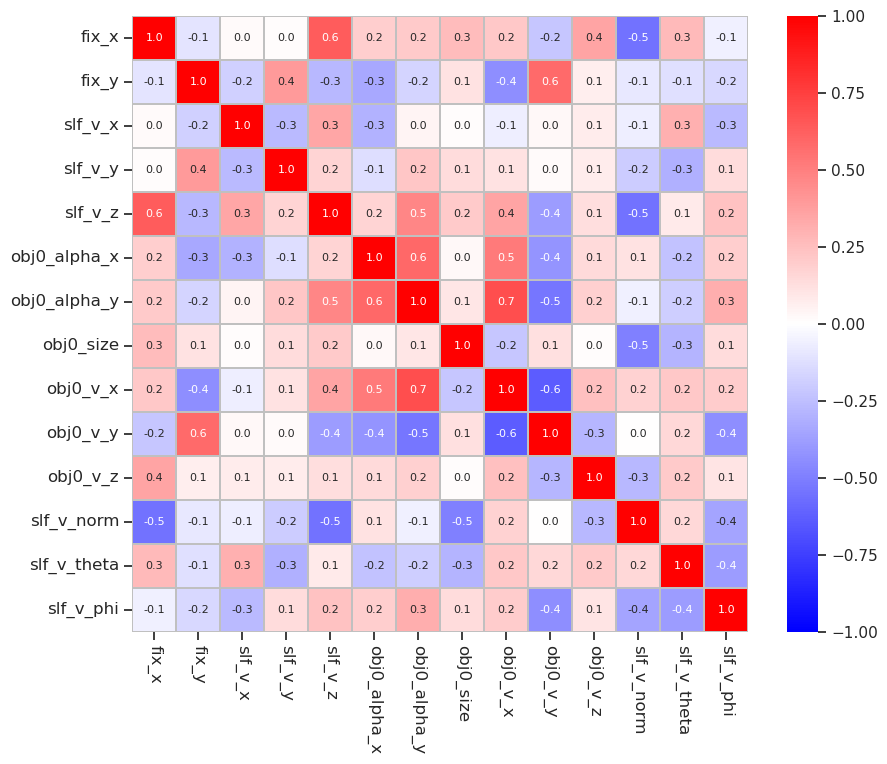

In [101]:
plot_heatmap(
    r=u @ u.T,
    xticklabels=u_all,
    yticklabels=u_all,
    figsize=(10, 8),
);

### Z-score

In [102]:
g_zscored = np.concatenate([v for v in g.values()])
mu = g_zscored.mean(0, keepdims=True)
sd = g_zscored.std(0, keepdims=True)

g_zscored = {
    k: (v - mu) / sd
    for k, v in g.items()
}
print({
    k: (v.mean(0).mean(), v.std(0).mean())
    for k, v in g_zscored.items()
})

{
    'trn': (-0.0001552203239358355, 0.9999721681464211),
    'vld': (0.0001768798982501835, 0.9998670914435488),
    'tst': (0.0010648826932356669, 1.0003359469796766)
}

In [103]:
z_zscored = np.concatenate([v for v in z.values()])
mu = z_zscored.mean(0, keepdims=True)
sd = z_zscored.std(0, keepdims=True)

z_zscored = {
    k: (v - mu) / sd
    for k, v in z.items()
}
print({
    k: (v.mean(0).mean(), v.std(0).mean())
    for k, v in z_zscored.items()
})

{
    'trn': (-7.9850076e-07, 0.9999362),
    'vld': (0.00011585294, 1.0006844),
    'tst': (7.2752982e-06, 1.000606)
}

In [104]:
u_all, r2_all = {}, {}
for idx, lbl in tqdm(enumerate(select_lbl), total=len(select_lbl)):
    # fit + get coeff
    lr = sk_linear.LinearRegression().fit(z_zscored['trn'], g_zscored['trn'][:, idx])
    u_all[lbl] = lr.coef_ / sp_lin.norm(lr.coef_)
    # r2
    pred = lr.predict(np.concatenate([z_zscored['vld'], z_zscored['tst']]))
    true = np.concatenate([g_zscored['vld'], g_zscored['tst']])[:, idx]
    r2 = sk_metric.r2_score(true, pred)
    r2_all[lbl] = r2
np.mean(list(r2_all.values()))

100%|███████████████████████████████████████████| 14/14 [01:16<00:00,  5.44s/it]


0.8977456554359408

In [105]:
pred = lr.predict(z_zscored['trn'])
true = g_zscored['trn'][:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.6230359317308325

In [106]:
u = np.stack(list(u_all.values()))
u.shape

(14, 490)

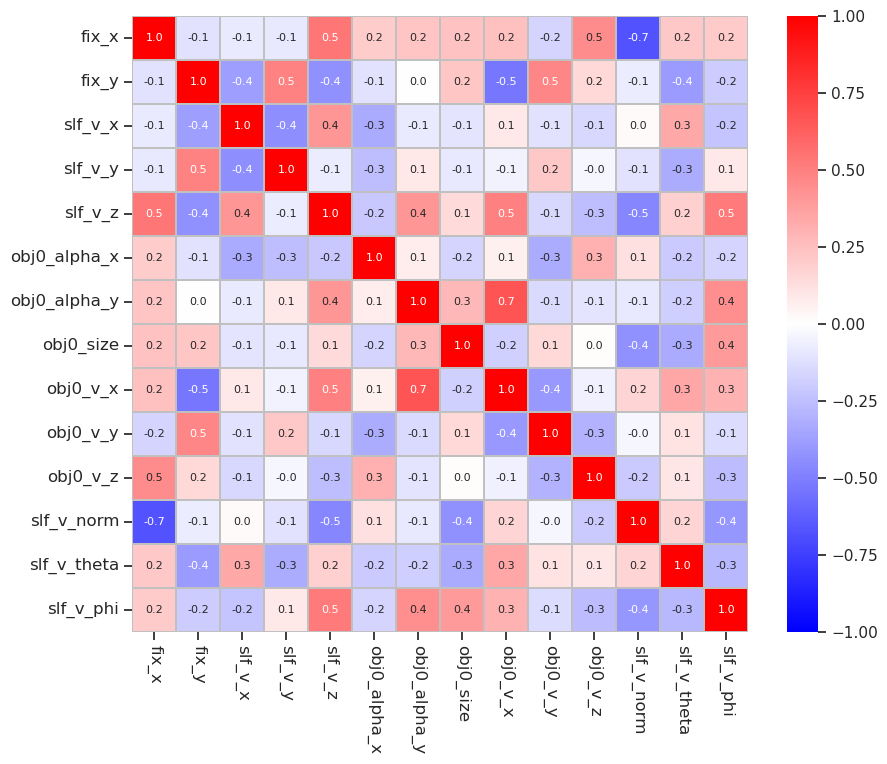

In [107]:
plot_heatmap(
    r=u @ u.T,
    xticklabels=u_all,
    yticklabels=u_all,
    figsize=(10, 8),
);

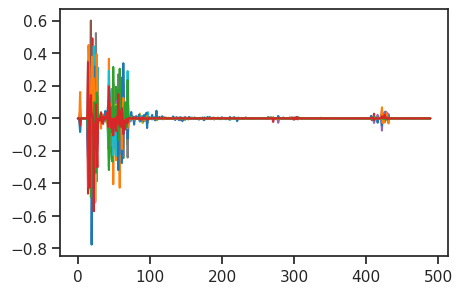

In [109]:
plt.plot(u.T);

## Corr between z

In [113]:
r = 1 - sp_dist.pdist(z['trn'].T, metric='correlation')
r = sp_dist.squareform(r)
r.shape

(490, 490)

In [118]:
tr.model.cfg.groups

[20, 10, 5]

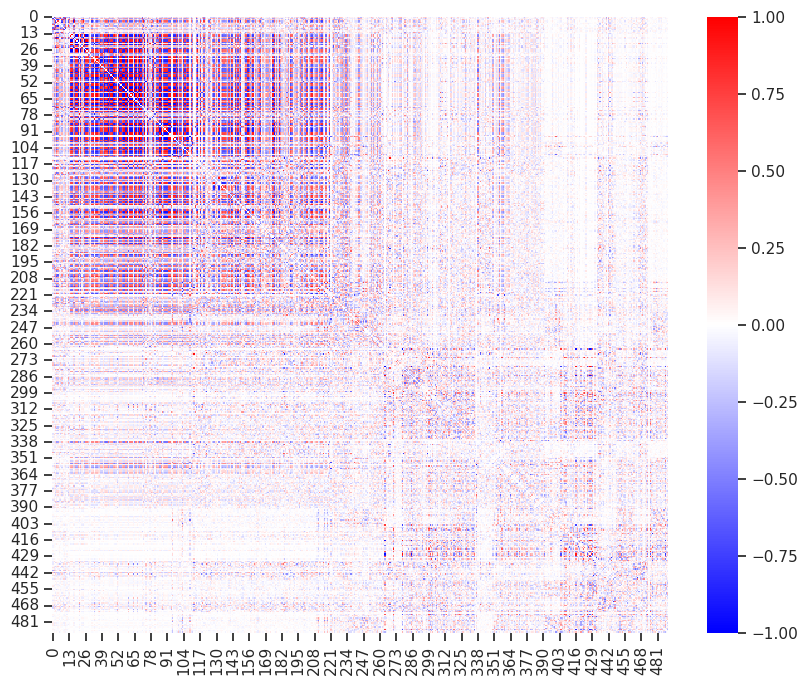

In [116]:
plot_heatmap(r, annot=False, linewidths=0);

/home/hadi/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


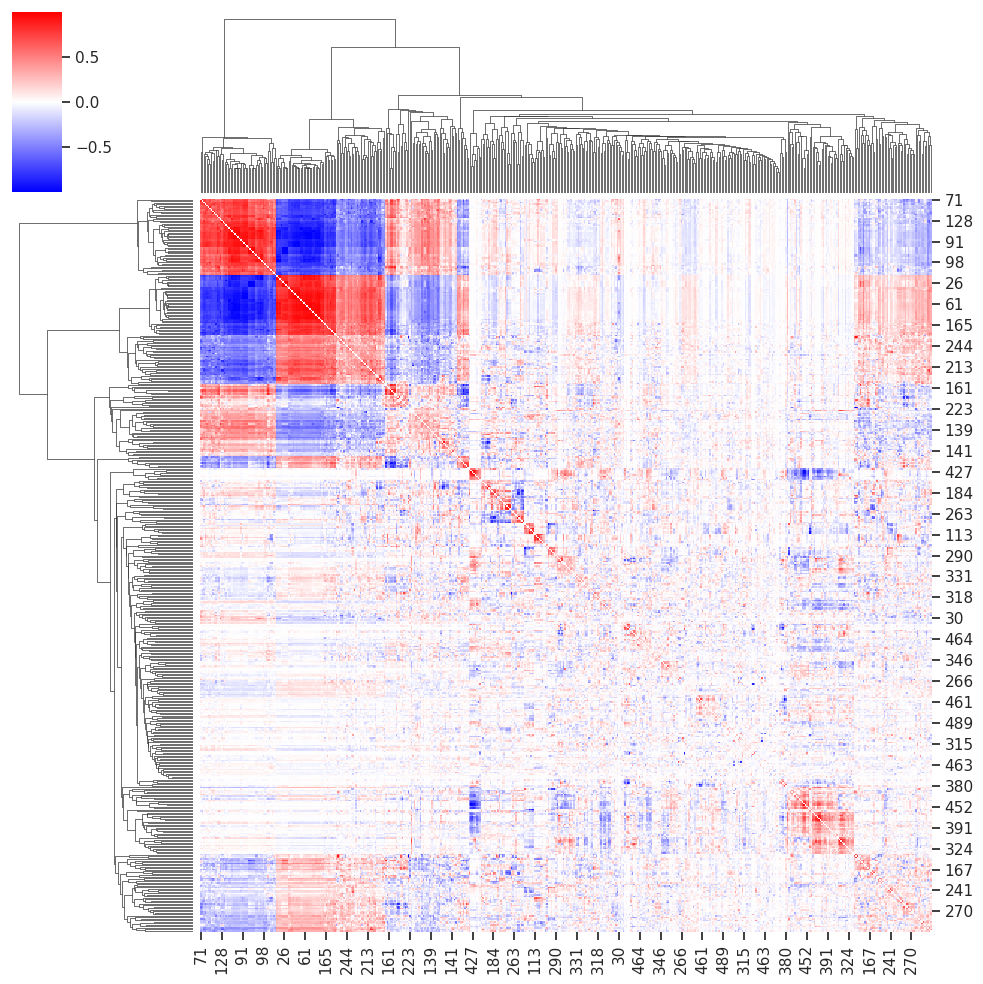

In [137]:
sns.clustermap(r, cmap='bwr');

In [138]:
from sklearn.cluster import KMeans

In [139]:
km = KMeans(3).fit(r)
cluster_ids = km.labels_ + 1

In [140]:
collections.Counter(cluster_ids[:14*5]).most_common()

[(1, 26), (2, 25), (3, 19)]

In [141]:
collections.Counter(cluster_ids[14*5:14*(5+10)]).most_common()

[(3, 54), (2, 45), (1, 41)]

In [142]:
collections.Counter(cluster_ids[14*(5+10):]).most_common()

[(3, 260), (2, 10), (1, 10)]